In [1]:
from models import make_classification_models
import torch.fx as fx

models = make_classification_models(32, 2)

In [2]:
C5 = models["C5"]
str(C5)

'Sequential(\n  (0): Linear(in_features=32, out_features=128, bias=True)\n  (1): ReLU()\n  (2): Linear(in_features=128, out_features=64, bias=True)\n  (3): ReLU()\n  (4): Linear(in_features=64, out_features=2, bias=True)\n)'

C:\Users\nikod\AppData\Local\Temp\ipykernel_10492\517031605.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


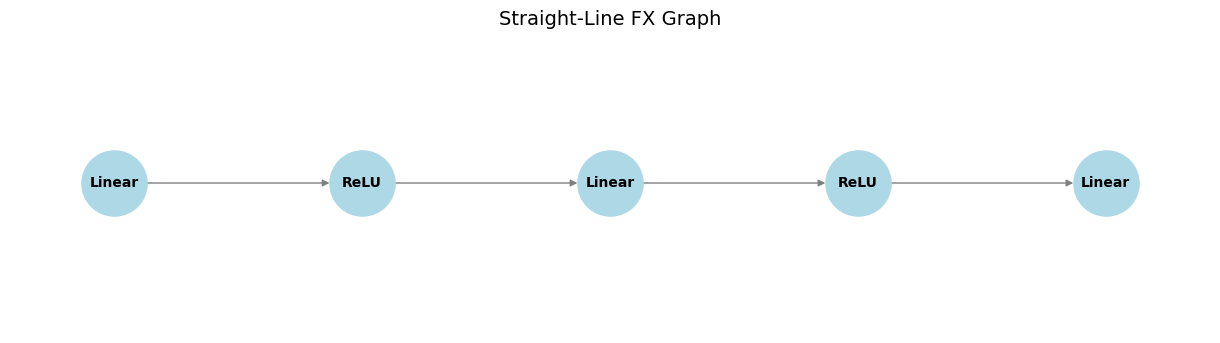

In [ ]:
import torch.nn as nn
import torch.fx as fx
import matplotlib.pyplot as plt
import networkx as nx

def trace_model_to_graph(model, include_params=False):
    traced = fx.symbolic_trace(model)
    nodes = []
    edges = []

    node_ids = {}
    current_id = 0

    for node in traced.graph.nodes:
        if node.op in ['call_module', 'call_function']:
            node_ids[node] = current_id
            layer_name = ""
            if node.op == 'call_module':
                submod = dict(model.named_modules()).get(node.target, None)
                layer_name = type(submod).__name__ if submod else str(node.target)
            elif node.op == 'call_function':
                layer_name = str(node.target).split('.')[-1]
            if include_params and node.op == 'call_module' and submod:
                params = {k: tuple(v.shape) for k, v in submod.state_dict().items()}
                label = f"{layer_name}\n{params}"
            else:
                label = layer_name
            nodes.append((current_id, label))
            current_id += 1

    for node in traced.graph.nodes:
        if node.op in ['call_module', 'call_function']:
            for input_node in node.all_input_nodes:
                if input_node in node_ids:
                    edges.append((node_ids[input_node], node_ids[node]))

    return nodes, edges

def visualize_graph_linear(nodes, edges, figsize=(12, 3)):
    G = nx.DiGraph()
    for node_id, label in nodes:
        G.add_node(node_id, label=label)
    for src, dst in edges:
        G.add_edge(src, dst)

    pos = {node_id: (i * 2, 0) for i, (node_id, _) in enumerate(nodes)}
    labels = nx.get_node_attributes(G, 'label')

    plt.figure(figsize=figsize)
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_size=2200, node_color="lightblue",
            font_size=10, font_weight='bold', edge_color='gray')
    plt.title("Straight-Line FX Graph", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

nodes, edges = trace_model_to_graph(C5)
visualize_graph_linear(nodes, edges)

### Helpers for plotting

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def model_size_key(size_str):
    try:
        return sum(int(x) for x in size_str.strip("[]").split(","))
    except:
        return 0

df = pd.read_csv("benchmark_scalability_results.csv")
df["model_size_str"] = df["model_size"].apply(lambda x: x.strip("[]").replace(", ", "-"))
df["model_size_num"] = df["model_size"].apply(lambda x: model_size_key(x))

df["avg_compare_time"] = df[[
    "string_time",
    "graph_structural_time",
    "graph_structural_with_params_time"
]].mean(axis=1)

train_df = df.groupby(["model_size_str", "model_size_num", "dataset"]).agg({
    "train_time": "mean",
    "avg_compare_time": "mean"
}).reset_index()

train_df = train_df.sort_values("model_size_num")

fig, ax = plt.subplots(figsize=(10, 6))
for dataset in train_df["dataset"].unique():
    subset = train_df[train_df["dataset"] == dataset]
    ax.plot(subset["model_size_str"], subset["train_time"], marker='o', label=f"{dataset} – trenowanie")
    ax.plot(subset["model_size_str"], subset["avg_compare_time"], marker='x', linestyle='--', label=f"{dataset} – porównanie")

ax.set_xlabel("Rozmiar modelu")
ax.set_ylabel("Czas (s)")
ax.set_title("Czas trenowania vs czas porównania architektur")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("train_vs_compare_time.png")
plt.close()

scal_df = df.groupby(["model_size_str", "model_size_num"]).agg({
    "string_time": "mean",
    "graph_structural_time": "mean",
    "graph_structural_with_params_time": "mean"
}).reset_index()

scal_df = scal_df.sort_values("model_size_num")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(scal_df["model_size_str"], scal_df["string_time"], marker='o', label="String-based")
ax.plot(scal_df["model_size_str"], scal_df["graph_structural_time"], marker='s', label="Graph")
ax.plot(scal_df["model_size_str"], scal_df["graph_structural_with_params_time"], marker='^', label="Graph + Params")

ax.set_xlabel("Rozmiar modelu")
ax.set_ylabel("Czas porównania (s)")
ax.set_title("Skalowalność — czas porównania względem rozmiaru modelu")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("scalability_graph.png")
plt.close()